<a href="https://colab.research.google.com/github/jmohsbeck1/jpmc_mle/blob/final_project/DataDazzlers_DineOracle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [ ]:
import os
import warnings
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

In [45]:
#Dataframe and numerical library
import pandas as pd 
pd.set_option('display.max_columns', None)
import numpy as np

# JSON
from pandas.io.json import json_normalize

#Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# SQLite
import sqlite3

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

#Machine Learming Model
#Metrics
from sklearn.metrics import mutual_info_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#Linear Model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

#Ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Others
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

#Hyper parameter
from sklearn import neighbors, datasets, model_selection

# XGBoost
import xgboost as xgb

# Data Import

In [ ]:
#STEP 1: Import large dataset using opendatasets
if not os.path.exists('yelp-business-dataset'):
  print("Loading Keys")
  kaggle_key = 'ravikiranbutti'
  kaggle_value = '117268fa41345f39e5baeda66733a0c7'
  os.environ['KAGGLE_USERNAME'] = kaggle_key
  os.environ['KAGGLE_KEY'] = kaggle_value
  !mkdir -p /root/.kaggle
  with open('/root/.kaggle/kaggle.json', 'w') as kaggle_file:
    kaggle_file.write('{"username":"' + kaggle_key + '","key":"' + kaggle_value + '"}')

  print("Loading Data")
  !pip install kaggle
  !kaggle datasets download ravikiranbutti/yelp-business-dataset
  !unzip yelp-business-dataset.zip -d 'yelp-business-dataset'
  !rm yelp-business-dataset.zip

In [ ]:
#STEP 2: Load Business using chunk processing
business_chunks = pd.read_json("yelp-business-dataset/yelp_academic_dataset_business.json", lines=True, chunksize=1000000)
business = pd.concat(business_chunks) 

In [ ]:
#Print information
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


# Data Cleaning


In [ ]:
#Select only the restaurant
business = business[business['categories'].str.contains('Restaurants', na=False)]
business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52268 entries, 3 to 150340
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   52268 non-null  object 
 1   name          52268 non-null  object 
 2   address       52268 non-null  object 
 3   city          52268 non-null  object 
 4   state         52268 non-null  object 
 5   postal_code   52268 non-null  object 
 6   latitude      52268 non-null  float64
 7   longitude     52268 non-null  float64
 8   stars         52268 non-null  float64
 9   review_count  52268 non-null  int64  
 10  is_open       52268 non-null  int64  
 11  attributes    51703 non-null  object 
 12  categories    52268 non-null  object 
 13  hours         44990 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 6.0+ MB


In [ ]:
# Drop unimportant columns
business = business.drop(['business_id','name','address','latitude','longitude','hours'], axis=1)
business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52268 entries, 3 to 150340
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          52268 non-null  object 
 1   state         52268 non-null  object 
 2   postal_code   52268 non-null  object 
 3   stars         52268 non-null  float64
 4   review_count  52268 non-null  int64  
 5   is_open       52268 non-null  int64  
 6   attributes    51703 non-null  object 
 7   categories    52268 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.6+ MB


In [ ]:
business.head()

,city,state,postal_code,stars,review_count,is_open,attributes,categories
3,Philadelphia,PA,19107,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
5,Ashland City,TN,37015,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
8,Affton,MO,63123,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr..."
9,Nashville,TN,37207,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,..."
11,Tampa Bay,FL,33602,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks"


# Data Preprocessing - Attributes Column



In [ ]:
# Use json_normalize() function to normalize the JSON column
normalized_df = json_normalize(business['attributes'])

# Merge the new DataFrame with the original DataFrame and fill missing values with 0
business_normalized = pd.concat([business, normalized_df], axis=1)
business_normalized.fillna(0, inplace=True)

# Set value to 1 if present and 0 if absent
business_normalized[normalized_df.columns] = business_normalized[normalized_df.columns].applymap(lambda x: 1 if x != 0 else 0)

#drop attributes column
business_normalized.drop(columns=['attributes'], inplace=True)

business_normalized.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86405 entries, 3 to 52267
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   city                        86405 non-null  object 
 1   state                       86405 non-null  object 
 2   postal_code                 86405 non-null  object 
 3   stars                       86405 non-null  float64
 4   review_count                86405 non-null  float64
 5   is_open                     86405 non-null  float64
 6   categories                  86405 non-null  object 
 7   RestaurantsDelivery         86405 non-null  int64  
 8   OutdoorSeating              86405 non-null  int64  
 9   BusinessAcceptsCreditCards  86405 non-null  int64  
 10  BusinessParking             86405 non-null  int64  
 11  BikeParking                 86405 non-null  int64  
 12  RestaurantsPriceRange2      86405 non-null  int64  
 13  RestaurantsTakeOut          864

In [ ]:
business_normalized.head()

,city,state,postal_code,stars,review_count,is_open,categories,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,RestaurantsAttire,RestaurantsReservations,Ambience,GoodForKids,CoatCheck,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,WheelchairAccessible,HasTV,HappyHour,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,BestNights,BYOB,Corkage,BYOBCorkage,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance
3,Philadelphia,PA,19107,4.0,80.0,1.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Ashland City,TN,37015,2.0,6.0,1.0,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Affton,MO,63123,3.0,19.0,0.0,"Pubs, Restaurants, Italian, Bars, American (Tr...",1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Nashville,TN,37207,1.5,10.0,1.0,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,Tampa Bay,FL,33602,4.0,10.0,1.0,"Vietnamese, Food, Restaurants, Food Trucks",1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Feature Selection - Attributes Column

In [ ]:
#NOTE: Add to sample it because of memory restrictions
business_feature_selection = business_normalized.sample(n=25000, random_state=42)

# Separate the features and the target variable
X = business_feature_selection.drop(['is_open','categories'], axis=1)
y = business_feature_selection['is_open']

# Assume df is the original dataframe with non-numerical columns
# Get all non-numerical columns and perform one-hot encoding
non_numeric_cols = list(business_feature_selection.select_dtypes(exclude=['number', 'bool']).columns)
one_hot_encoded = pd.get_dummies(business_feature_selection[non_numeric_cols])

# Combine one-hot encoded columns with numerical columns
numerical_cols = list(business_feature_selection.select_dtypes(include=['number', 'bool']).columns)
X = pd.concat([business_feature_selection[numerical_cols], one_hot_encoded], axis=1)

# Select the top 10 features using f_classif score
selector = SelectKBest(score_func=f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]

# Print the selected feature names
print('Selected features:', list(selected_features))

Selected features: ['stars', 'is_open', 'RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'WiFi', 'Alcohol', 'RestaurantsAttire', 'RestaurantsReservations', 'Ambience', 'GoodForKids', 'RestaurantsGoodForGroups', 'HasTV', 'city_0', 'state_0', 'postal_code_0', 'categories_0']


In [ ]:
#Data cleaning, remove columns already in the business set
selected_features = {item for item in selected_features if not item.startswith('categories')}
selected_features = {item for item in selected_features if not item.startswith('city_')}
selected_features = {item for item in selected_features if not item.startswith('state_')}
selected_features = {item for item in selected_features if not item.startswith('postal_code_')}
index = pd.Index(selected_features)

# select only columns in the Index object
business_normalized = pd.concat([business_normalized['categories'], business_normalized.loc[:, index]], axis=1)
business_normalized.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86405 entries, 3 to 52267
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   categories                  86405 non-null  object 
 1   RestaurantsTakeOut          86405 non-null  int64  
 2   RestaurantsReservations     86405 non-null  int64  
 3   Alcohol                     86405 non-null  int64  
 4   GoodForKids                 86405 non-null  int64  
 5   stars                       86405 non-null  float64
 6   is_open                     86405 non-null  float64
 7   WiFi                        86405 non-null  int64  
 8   RestaurantsPriceRange2      86405 non-null  int64  
 9   BusinessAcceptsCreditCards  86405 non-null  int64  
 10  RestaurantsGoodForGroups    86405 non-null  int64  
 11  Ambience                    86405 non-null  int64  
 12  OutdoorSeating              86405 non-null  int64  
 13  RestaurantsDelivery         864

In [ ]:
business_normalized.head()

,categories,RestaurantsTakeOut,RestaurantsReservations,Alcohol,GoodForKids,stars,is_open,WiFi,RestaurantsPriceRange2,BusinessAcceptsCreditCards,RestaurantsGoodForGroups,Ambience,OutdoorSeating,RestaurantsDelivery,HasTV,RestaurantsAttire,BusinessParking
3,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1,1,1,1,4.0,1.0,1,1,1,1,0,1,1,1,1,1
5,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",1,1,1,1,2.0,1.0,1,1,1,1,1,1,1,1,1,1
8,"Pubs, Restaurants, Italian, Bars, American (Tr...",1,1,1,1,3.0,0.0,1,1,1,1,1,1,1,1,1,1
9,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",1,1,1,1,1.5,1.0,1,1,0,1,1,1,1,1,1,1
11,"Vietnamese, Food, Restaurants, Food Trucks",1,1,1,1,4.0,1.0,1,1,1,1,1,1,1,1,1,1


# # Data Preprocessing - Categories Column

In [ ]:
# Extract categories column into separate DataFrame
categories_df = business_normalized[['categories']]

# Convert categories column to lowercase and remove leading/trailing white spaces
categories_df['categories'] = categories_df['categories'].str.lower().str.strip()

# Split comma-separated categories into separate columns
categories_df = categories_df['categories'].str.split(',', expand=True)

# Stack the newly created columns
categories_df = categories_df.stack()

# Create dummy variables for each unique category
categories_df = pd.get_dummies(categories_df, prefix='', prefix_sep='')

# Group dummy variables by index and sum them
categories_df = categories_df.groupby(level=0).sum()

# Rename the columns with their original names
categories_df.columns = categories_df.columns.str.replace(' ', 'ct_')

# Group dummy variables by index and sum them
categories_df = categories_df.groupby(level=0).sum()

# Normalize the resulting DataFrame
categories_df = categories_df.div(categories_df.sum(axis=1), axis=0)

#Data cleaning
categories_df = categories_df.applymap(lambda x: 1 if x > 0.0 else 0)
categories_df.drop(columns=['restaurants','ct_restaurants'], inplace=True)

# Merge the new dataframe with the original dataframe
business_normalized = business_normalized.join(categories_df)

#drop categories column
business_normalized.drop(columns=['categories'], inplace=True)

business_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86405 entries, 3 to 52267
Columns: 1140 entries, RestaurantsTakeOut to yoga
dtypes: float64(1126), int64(14)
memory usage: 754.2 MB


In [ ]:
print(business_normalized.columns.tolist())

['RestaurantsTakeOut', 'RestaurantsReservations', 'Alcohol', 'GoodForKids', 'stars', 'is_open', 'WiFi', 'RestaurantsPriceRange2', 'BusinessAcceptsCreditCards', 'RestaurantsGoodForGroups', 'Ambience', 'OutdoorSeating', 'RestaurantsDelivery', 'HasTV', 'RestaurantsAttire', 'BusinessParking', 'ct_acaict_bowls', 'ct_accessories', 'ct_accountants', 'ct_activect_life', 'ct_acupuncture', 'ct_adult', 'ct_adultct_entertainment', 'ct_advertising', 'ct_afghan', 'ct_african', 'ct_airct_ductct_cleaning', 'ct_airlines', 'ct_airportct_lounges', 'ct_airportct_shuttles', 'ct_airportct_terminals', 'ct_airports', 'ct_amateurct_sportsct_teams', 'ct_americanct_(new)', 'ct_americanct_(traditional)', 'ct_amusementct_parks', 'ct_animalct_shelters', 'ct_antiques', 'ct_apartments', 'ct_appliances', 'ct_appliancesct_&ct_repair', 'ct_aquariums', 'ct_arabic', 'ct_arcades', 'ct_argentine', 'ct_armenian', 'ct_artct_classes', 'ct_artct_galleries', 'ct_artct_museums', 'ct_artct_tours', 'ct_artsct_&ct_crafts', 'ct_artsc

In [ ]:
business_normalized.head()

,RestaurantsTakeOut,RestaurantsReservations,Alcohol,GoodForKids,stars,is_open,WiFi,RestaurantsPriceRange2,BusinessAcceptsCreditCards,RestaurantsGoodForGroups,Ambience,OutdoorSeating,RestaurantsDelivery,HasTV,RestaurantsAttire,BusinessParking,ct_acaict_bowls,ct_accessories,ct_accountants,ct_activect_life,ct_acupuncture,ct_adult,ct_adultct_entertainment,ct_advertising,ct_afghan,ct_african,ct_airct_ductct_cleaning,ct_airlines,ct_airportct_lounges,ct_airportct_shuttles,ct_airportct_terminals,ct_airports,ct_amateurct_sportsct_teams,ct_americanct_(new),ct_americanct_(traditional),ct_amusementct_parks,ct_animalct_shelters,ct_antiques,ct_apartments,ct_appliances,ct_appliancesct_&ct_repair,ct_aquariums,ct_arabic,ct_arcades,ct_argentine,ct_armenian,ct_artct_classes,ct_artct_galleries,ct_artct_museums,ct_artct_tours,ct_artsct_&ct_crafts,ct_artsct_&ct_entertainment,ct_asianct_fusion,ct_auctionct_houses,ct_audio/visualct_equipmentct_rental,ct_australian,ct_austrian,ct_autoct_customization,ct_autoct_detailing,ct_autoct_glassct_services,ct_autoct_loanct_providers,ct_autoct_partsct_&ct_supplies,ct_autoct_repair,ct_automotive,ct_axect_throwing,ct_bagels,ct_bakeries,ct_bangladeshi,ct_banksct_&ct_creditct_unions,ct_barct_crawl,ct_barbeque,ct_barbers,ct_bars,ct_bartenders,ct_basque,ct_batteryct_stores,ct_battingct_cages,ct_beachct_bars,ct_beaches,ct_beautyct_&ct_spas,ct_bedct_&ct_breakfast,ct_beer,ct_beerct_bar,ct_beerct_gardens,ct_beerct_hall,ct_beerct_tours,ct_belgian,ct_beveragect_store,ct_bikect_rentals,ct_bikect_repair/maintenance,ct_bikes,ct_bistros,ct_boatct_charters,ct_boatct_tours,ct_boating,ct_boccect_ball,ct_bodyct_shops,ct_books,ct_bookstores,ct_botanicalct_gardens,ct_bowling,ct_brasseries,ct_brazilian,ct_breakfastct_&ct_brunch,ct_breweries,ct_brewingct_supplies,ct_brewpubs,ct_bridal,ct_british,ct_bubblect_tea,ct_buddhistct_temples,ct_buffets,ct_buildingct_supplies,ct_burgers,ct_burmese,ct_busct_tours,ct_businessct_consulting,ct_businessct_law,ct_butcher,ct_cabaret,ct_cafes,ct_cafeteria,ct_cajun/creole,ct_calabrian,ct_cambodian,ct_canadianct_(new),ct_candlect_stores,ct_candyct_stores,ct_cannabisct_clinics,ct_cannabisct_dispensaries,ct_cantonese,ct_carct_dealers,ct_carct_sharect_services,ct_carct_stereoct_installation,ct_carct_wash,ct_cardsct_&ct_stationery,ct_caribbean,ct_carpetct_cleaning,ct_casinos,ct_caterers,ct_champagnect_bars,ct_checkct_cashing/pay-dayct_loans,ct_cheesect_shops,ct_cheesesteaks,ct_chickenct_shop,ct_chickenct_wings,ct_childct_carect_&ct_dayct_care,ct_children'sct_clothing,ct_chinese,ct_chiropractors,ct_chocolatiersct_&ct_shops,ct_christmasct_trees,ct_churches,ct_cideries,ct_cigarct_bars,ct_cinema,ct_climbing,ct_clothingct_rental,ct_clubct_crawl,ct_cocktailct_bars,ct_coffeect_&ct_tea,ct_coffeect_&ct_teact_supplies,ct_coffeect_roasteries,ct_coffeeshops,ct_collegesct_&ct_universities,ct_colombian,ct_comedyct_clubs,ct_comfortct_food,ct_comicct_books,ct_commercialct_truckct_dealers,ct_commercialct_truckct_repair,ct_communityct_service/non-profit,ct_contractct_law,ct_contractors,ct_conveniencect_stores,ct_conveyorct_beltct_sushi,ct_cookingct_classes,ct_cookingct_schools,ct_cosmeticct_surgeons,ct_cosmeticsct_&ct_beautyct_supply,ct_costumes,ct_counselingct_&ct_mentalct_health,ct_countertopct_installation,ct_countryct_clubs,ct_countryct_dancect_halls,ct_couriersct_&ct_deliveryct_services,ct_cranect_services,ct_creperies,ct_csa,ct_cuban,ct_cucinact_campana,ct_culturalct_center,ct_cupcakes,ct_customct_cakes,ct_customizedct_merchandise,ct_czech,ct_damagect_restoration,ct_dancect_clubs,ct_dancect_schools,ct_dancect_studios,ct_dayct_spas,ct_delicatessen,ct_delis,ct_dentists,ct_departmentct_stores,ct_departmentsct_ofct_motorct_vehicles,ct_desserts,ct_diagnosticct_services,ct_dietitians,ct_dimct_sum,ct_diners,ct_dinnerct_theater,ct_discountct_store,ct_distilleries,ct_divect_bars,ct_divorcect_&ct_familyct_law,ct_djs,ct_do-it-yourselfct_food,ct_doctors,ct_dogct_parks,ct_dominican,ct_donairs,ct_donburi,ct_donuts,ct_drive-inct_theate

# Feature Selection - Categories Column


In [ ]:
#NOTE: Add to sample it because of memory restrictions
business_normalized.fillna(0, inplace=True)
business_feature_selection = business_normalized.sample(n=70000, random_state=42)

# Separate the features and the target variable
X = business_feature_selection.drop(['is_open'], axis=1)
y = business_feature_selection['is_open']

# Select the top 10 features using f_classif score
selector = SelectKBest(score_func=f_classif, k=30)
X_new = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]

# Print the selected feature names
print('Selected features:', set(selected_features))

Selected features: {'RestaurantsReservations', 'ct_eventct_planningct_&ct_services', 'ct_americanct_(traditional)', 'OutdoorSeating', 'ct_pizza', 'HasTV', 'ct_food', 'ct_chickenct_wings', 'ct_nightlife', 'ct_fastct_food', 'BusinessParking', 'stars', 'GoodForKids', 'Alcohol', 'WiFi', 'ct_breakfastct_&ct_brunch', 'RestaurantsGoodForGroups', 'fastct_food', 'RestaurantsDelivery', 'RestaurantsPriceRange2', 'RestaurantsAttire', 'ct_mexican', 'ct_bars', 'RestaurantsTakeOut', 'ct_salad', 'BusinessAcceptsCreditCards', 'Ambience', 'ct_coffeect_&ct_tea', 'ct_sandwiches', 'ct_burgers'}


In [ ]:
# Get a boolean mask indicating which columns were selected
selected_mask = selector.get_support()

# Select the desired columns using the mask
X_selected_columns = X.columns[selected_mask]

# Drop all columns not selected
business_normalized = pd.concat([business_normalized['is_open'], business_normalized[X_selected_columns]], axis=1)
business_normalized.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 86405 entries, 3 to 52267
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   is_open                             86405 non-null  float64
 1   RestaurantsTakeOut                  86405 non-null  int64  
 2   RestaurantsReservations             86405 non-null  int64  
 3   Alcohol                             86405 non-null  int64  
 4   GoodForKids                         86405 non-null  int64  
 5   stars                               86405 non-null  float64
 6   WiFi                                86405 non-null  int64  
 7   RestaurantsPriceRange2              86405 non-null  int64  
 8   BusinessAcceptsCreditCards          86405 non-null  int64  
 9   RestaurantsGoodForGroups            86405 non-null  int64  
 10  Ambience                            86405 non-null  int64  
 11  OutdoorSeating                      86405

In [ ]:
business_normalized.head()

,is_open,RestaurantsTakeOut,RestaurantsReservations,Alcohol,GoodForKids,stars,WiFi,RestaurantsPriceRange2,BusinessAcceptsCreditCards,RestaurantsGoodForGroups,Ambience,OutdoorSeating,RestaurantsDelivery,HasTV,RestaurantsAttire,BusinessParking,ct_americanct_(traditional),ct_bars,ct_breakfastct_&ct_brunch,ct_burgers,ct_chickenct_wings,ct_coffeect_&ct_tea,ct_eventct_planningct_&ct_services,ct_fastct_food,ct_food,ct_mexican,ct_nightlife,ct_pizza,ct_salad,ct_sandwiches,fastct_food
3,1.0,1,1,1,1,4.0,1,1,1,1,0,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1,1,1,1,2.0,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,1,1,1,1,3.0,1,1,1,1,1,1,1,1,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1.0,1,1,1,1,1.5,1,1,0,1,1,1,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1.0,1,1,1,1,4.0,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Basic Data Cleaning
business.columns = business.columns.str.lower().str.replace(' ', '_') # A
 
string_columns = list(business.dtypes[business.dtypes == 'object'].index) # B
 
for col in string_columns:
    business[col] = business[col].astype(str).str.lower().str.replace(' ', '_')

In [ ]:
business_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86405 entries, 3 to 52267
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   is_open                             86405 non-null  float64
 1   RestaurantsTakeOut                  86405 non-null  int64  
 2   RestaurantsReservations             86405 non-null  int64  
 3   Alcohol                             86405 non-null  int64  
 4   GoodForKids                         86405 non-null  int64  
 5   stars                               86405 non-null  float64
 6   WiFi                                86405 non-null  int64  
 7   RestaurantsPriceRange2              86405 non-null  int64  
 8   BusinessAcceptsCreditCards          86405 non-null  int64  
 9   RestaurantsGoodForGroups            86405 non-null  int64  
 10  Ambience                            86405 non-null  int64  
 11  OutdoorSeating                      86405

In [ ]:
business_normalized.shape

(86405, 31)

In [ ]:
business_normalized.head()

,is_open,RestaurantsTakeOut,RestaurantsReservations,Alcohol,GoodForKids,stars,WiFi,RestaurantsPriceRange2,BusinessAcceptsCreditCards,RestaurantsGoodForGroups,Ambience,OutdoorSeating,RestaurantsDelivery,HasTV,RestaurantsAttire,BusinessParking,ct_americanct_(traditional),ct_bars,ct_breakfastct_&ct_brunch,ct_burgers,ct_chickenct_wings,ct_coffeect_&ct_tea,ct_eventct_planningct_&ct_services,ct_fastct_food,ct_food,ct_mexican,ct_nightlife,ct_pizza,ct_salad,ct_sandwiches,fastct_food
3,1.0,1,1,1,1,4.0,1,1,1,1,0,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1,1,1,1,2.0,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,1,1,1,1,3.0,1,1,1,1,1,1,1,1,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1.0,1,1,1,1,1.5,1,1,0,1,1,1,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1.0,1,1,1,1,4.0,1,1,1,1,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
business_normalized.to_csv("business_normalized.csv")

# Machine Learning

Call XGBoost Classifier without Hyperparamter tuning

In [35]:
# Separate the features and the target variable

X = business_normalized.drop(['is_open'], axis=1)
y = business_normalized['is_open']


In [36]:
# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Init classifier
xgb_cl = xgb.XGBClassifier()

In [38]:
# Fit
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [42]:
# Predict
y_pred = xgb_cl.predict(X_test)

In [43]:
# Score
accuracy_score(y_test, y_pred)

0.7993750361668885

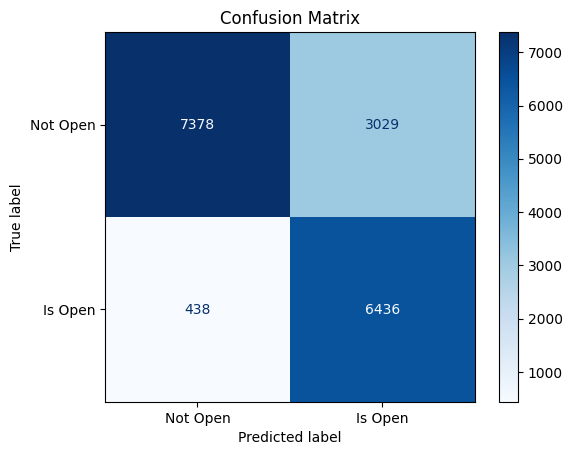

In [46]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Open", "Is Open"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Hyperparameter tuning